In [1]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
import tensorflow.keras.optimizers
# from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16

import numpy as np
import matplotlib.pyplot as plt
import os

from image_loader import get_data_location


In [2]:
os.path.expanduser('~/.keras/models/')

# original_file = r'D:\Class\Deep Learning Class\datasets\dogs-vs-cats.zip'
base_dir=r'D:\Class\Deep Learning Class\03- Load data and explore deep architectures\dogs-vs-cats'


In [3]:
train_dir, validation_dir, test_dir = get_data_location(base_dir=base_dir)

In [4]:
print(train_dir)
print(validation_dir)
print(test_dir)

D:\Class\Deep Learning Class\03- Load data and explore deep architectures\dogs-vs-cats\train
D:\Class\Deep Learning Class\03- Load data and explore deep architectures\dogs-vs-cats\validation
D:\Class\Deep Learning Class\03- Load data and explore deep architectures\dogs-vs-cats\test


In [5]:
# Load convolution layers of model and ignore (dont load) FC layers
conv_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150, 150, 3))

In [6]:
# conv_base.summary()

In [7]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# test data must NOT be augmented.
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_data_gen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

In [9]:
data_gen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_feature(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512 ))
    labels = np.zeros(shape= sample_count)
    
    generator = data_gen.flow_from_directory(
        directory, 
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    i = 0 
    for inputs_batch, label_batch in generator:
        features_batch=conv_base.predict(inputs_batch, verbose=0)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = label_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
        
    return features, labels

In [10]:
%%time
train_features, train_labels = extract_feature(train_dir, 2000) #2000

Found 2000 images belonging to 2 classes.
CPU times: total: 14min 36s
Wall time: 3min 31s


In [11]:
%%time
validation_features, validation_labels = extract_feature(validation_dir, 1000) # 1000

Found 1000 images belonging to 2 classes.
CPU times: total: 7min 31s
Wall time: 1min 48s


In [12]:
%%time
test_features, test_labels = extract_feature(test_dir, 1000) # 1000

Found 1000 images belonging to 2 classes.
CPU times: total: 7min 48s
Wall time: 1min 47s


In [13]:
train_features.shape

(2000, 4, 4, 512)

In [14]:
# cache data
train_features_np =np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features_np =np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features_np =np.reshape(test_features, (1000, 4 * 4 * 512))

In [15]:
train_features_np.shape

(2000, 8192)

## Create our new model

In [16]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,097,665 (8.00 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer=RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc']
             )

In [19]:
train_features_np.shape

(2000, 8192)

In [20]:
train_labels.shape

(2000,)

In [21]:
history = model.fit(x=train_features_np,
                    y=train_labels,
                    batch_size=20,
                    epochs=30,
                    validation_data=(validation_features_np, validation_labels))

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - acc: 0.5950 - loss: 0.6817 - val_acc: 0.8370 - val_loss: 0.4571
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.7886 - loss: 0.4612 - val_acc: 0.8640 - val_loss: 0.3728
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.8312 - loss: 0.3768 - val_acc: 0.8850 - val_loss: 0.3310
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.8651 - loss: 0.3257 - val_acc: 0.8880 - val_loss: 0.3054
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.8734 - loss: 0.2947 - val_acc: 0.8860 - val_loss: 0.2979
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.8922 - loss: 0.2827 - val_acc: 0.8920 - val_loss: 0.2813
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.8851 - loss: 0.2710 - val_acc: 0.8880 - val_loss: 0.2791
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.9062 - loss: 0.2418 - val_acc: 0.8940 - val_loss: 0.2657
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/

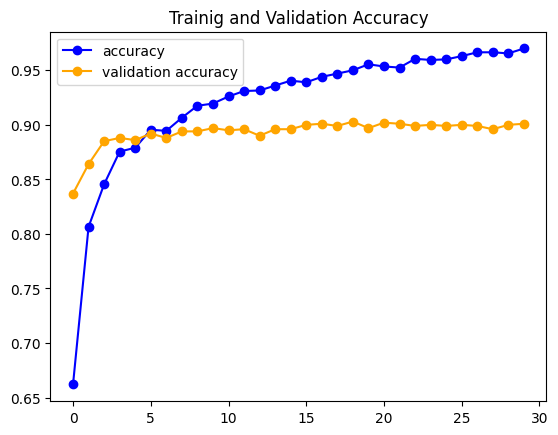

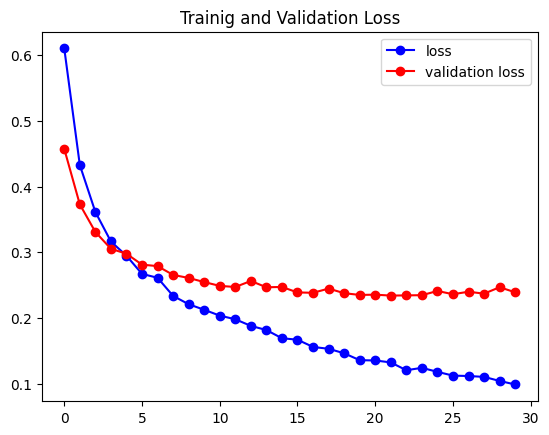

In [22]:
plt.plot(history.history['acc'], marker='o', color='blue',label='accuracy')
plt.plot(history.history['val_acc'], marker='o' ,color='orange' ,label='validation accuracy')
plt.title('Trainig and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(history.history['loss'],  marker='o', color='blue',label='loss')
plt.plot(history.history['val_loss'],  marker='o', color='red',label='validation loss')
plt.title('Trainig and Validation Loss')
plt.legend()
